In [38]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import npeb
from npeb.GLMixture import GLMixture
import itertools
from scipy.linalg import sqrtm, inv
from scipy.spatial import distance_matrix
import ot

In [43]:
n = 2500
center1 = np.asarray([0.5, 0.5])
center2 = np.asarray([-0.5, -0.5])
tau2 = 0.1
sigma2 = 1.0

np.random.seed(54321)

In [56]:
centers = np.vstack([center1, center2])

def sample_latent(nsamples, var):
  classes = np.random.randint(0, 2, size = nsamples)
  indices = np.zeros((nsamples, 2))
  indices[np.arange(nsamples), classes] = 1
  Theta = np.random.normal(indices@centers, np.sqrt(var))
  return Theta

In [64]:
centers[:, 0]
centers[:, 1]

array([ 0.5, -0.5])

In [86]:
Theta = sample_latent(n, tau2)
prec = np.ones_like(Theta)/sigma2
prec_smooth = 1./(1./prec + tau2)
Z = np.random.normal(Theta, np.sqrt(sigma2), size = (n, 2))
L = np.max(Z)

## Compute denoisers

### (Unconstrained) oracle Bayes -- many posterior samples

In [87]:
ob_model = GLMixture(prec_type='diagonal')
n_supp = 10000 # number of (empirical) support points to have for the oracle prior
supp = sample_latent(n_supp,tau2) # this defines the (empirical) (oracle) prior support 
ob_model.set_params(atoms=supp, weights=np.ones(n_supp)/n_supp)
ob_means = ob_model.posterior_mean(Z, prec)
prior_weights, ob_samples = ob_model.posterior_sample(Z, prec, n_samples=2500)

### (Unconstrained) empirical Bayes -- many posterior samples


In [88]:
eb_model_h = GLMixture(prec_type='diagonal')
eb_model_h.fit(Z, prec_smooth)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


[np.float64(-3.107786027693463),
 np.float64(-3.1077840778469654),
 np.float64(-3.107782936499911),
 np.float64(-3.1077820382360515),
 np.float64(-3.1077812642195375),
 np.float64(-3.1077805707947306),
 np.float64(-3.107779939577568),
 np.float64(-3.1077793610871742),
 np.float64(-3.1077788291961244),
 np.float64(-3.107778339198729),
 np.float64(-3.107777887118938)]

In [93]:
h_hat_supp = eb_model_h.atoms
h_hat_weights = eb_model_h.weights
# sample n = 2500 points from h_hat_supp with weights h_hat_weights and then add gaussian noise of tau^2 to get (discrete) estimated prior.
n = 2500
g_hat_samples = np.zeros((n, 2))
for i in range(n):
    idx = np.random.choice(len(h_hat_supp), p=h_hat_weights)
    h_hat_sample = h_hat_supp[idx]
    g_hat_samples[i] = h_hat_sample + np.random.normal(0, np.sqrt(tau2), size=2)

In [99]:
est_prior_weights_h, h_samples = eb_model_h.posterior_sample(Z, prec_smooth, n_samples=2500)
eb_means_h = eb_model_h.posterior_mean(Z, prec_smooth)
post_theta_means = eb_means_h * sigma2 / (sigma2 + tau2) + Z * tau2 / (sigma2 + tau2)
post_theta_samples = post_theta_means + np.random.normal(0, np.sqrt(sigma2*tau2/(sigma2 + tau2)), size=(n,2))

In [107]:
eb_model_g = GLMixture(prec_type='diagonal')
eb_model_g.fit(Z, prec)
est_prior_weights_g, g_samples = eb_model_g.posterior_sample(Z, prec, n_samples=2500)
eb_means_g = eb_model_g.posterior_mean(Z, prec)

Selecting all data points as atoms: done.
Computing kernel matrix: done.
Solving for discretized NPMLE: done.


In [108]:
est_g = eb_model_g.atoms
est_g_weights = eb_model_g.weights

## Plotting

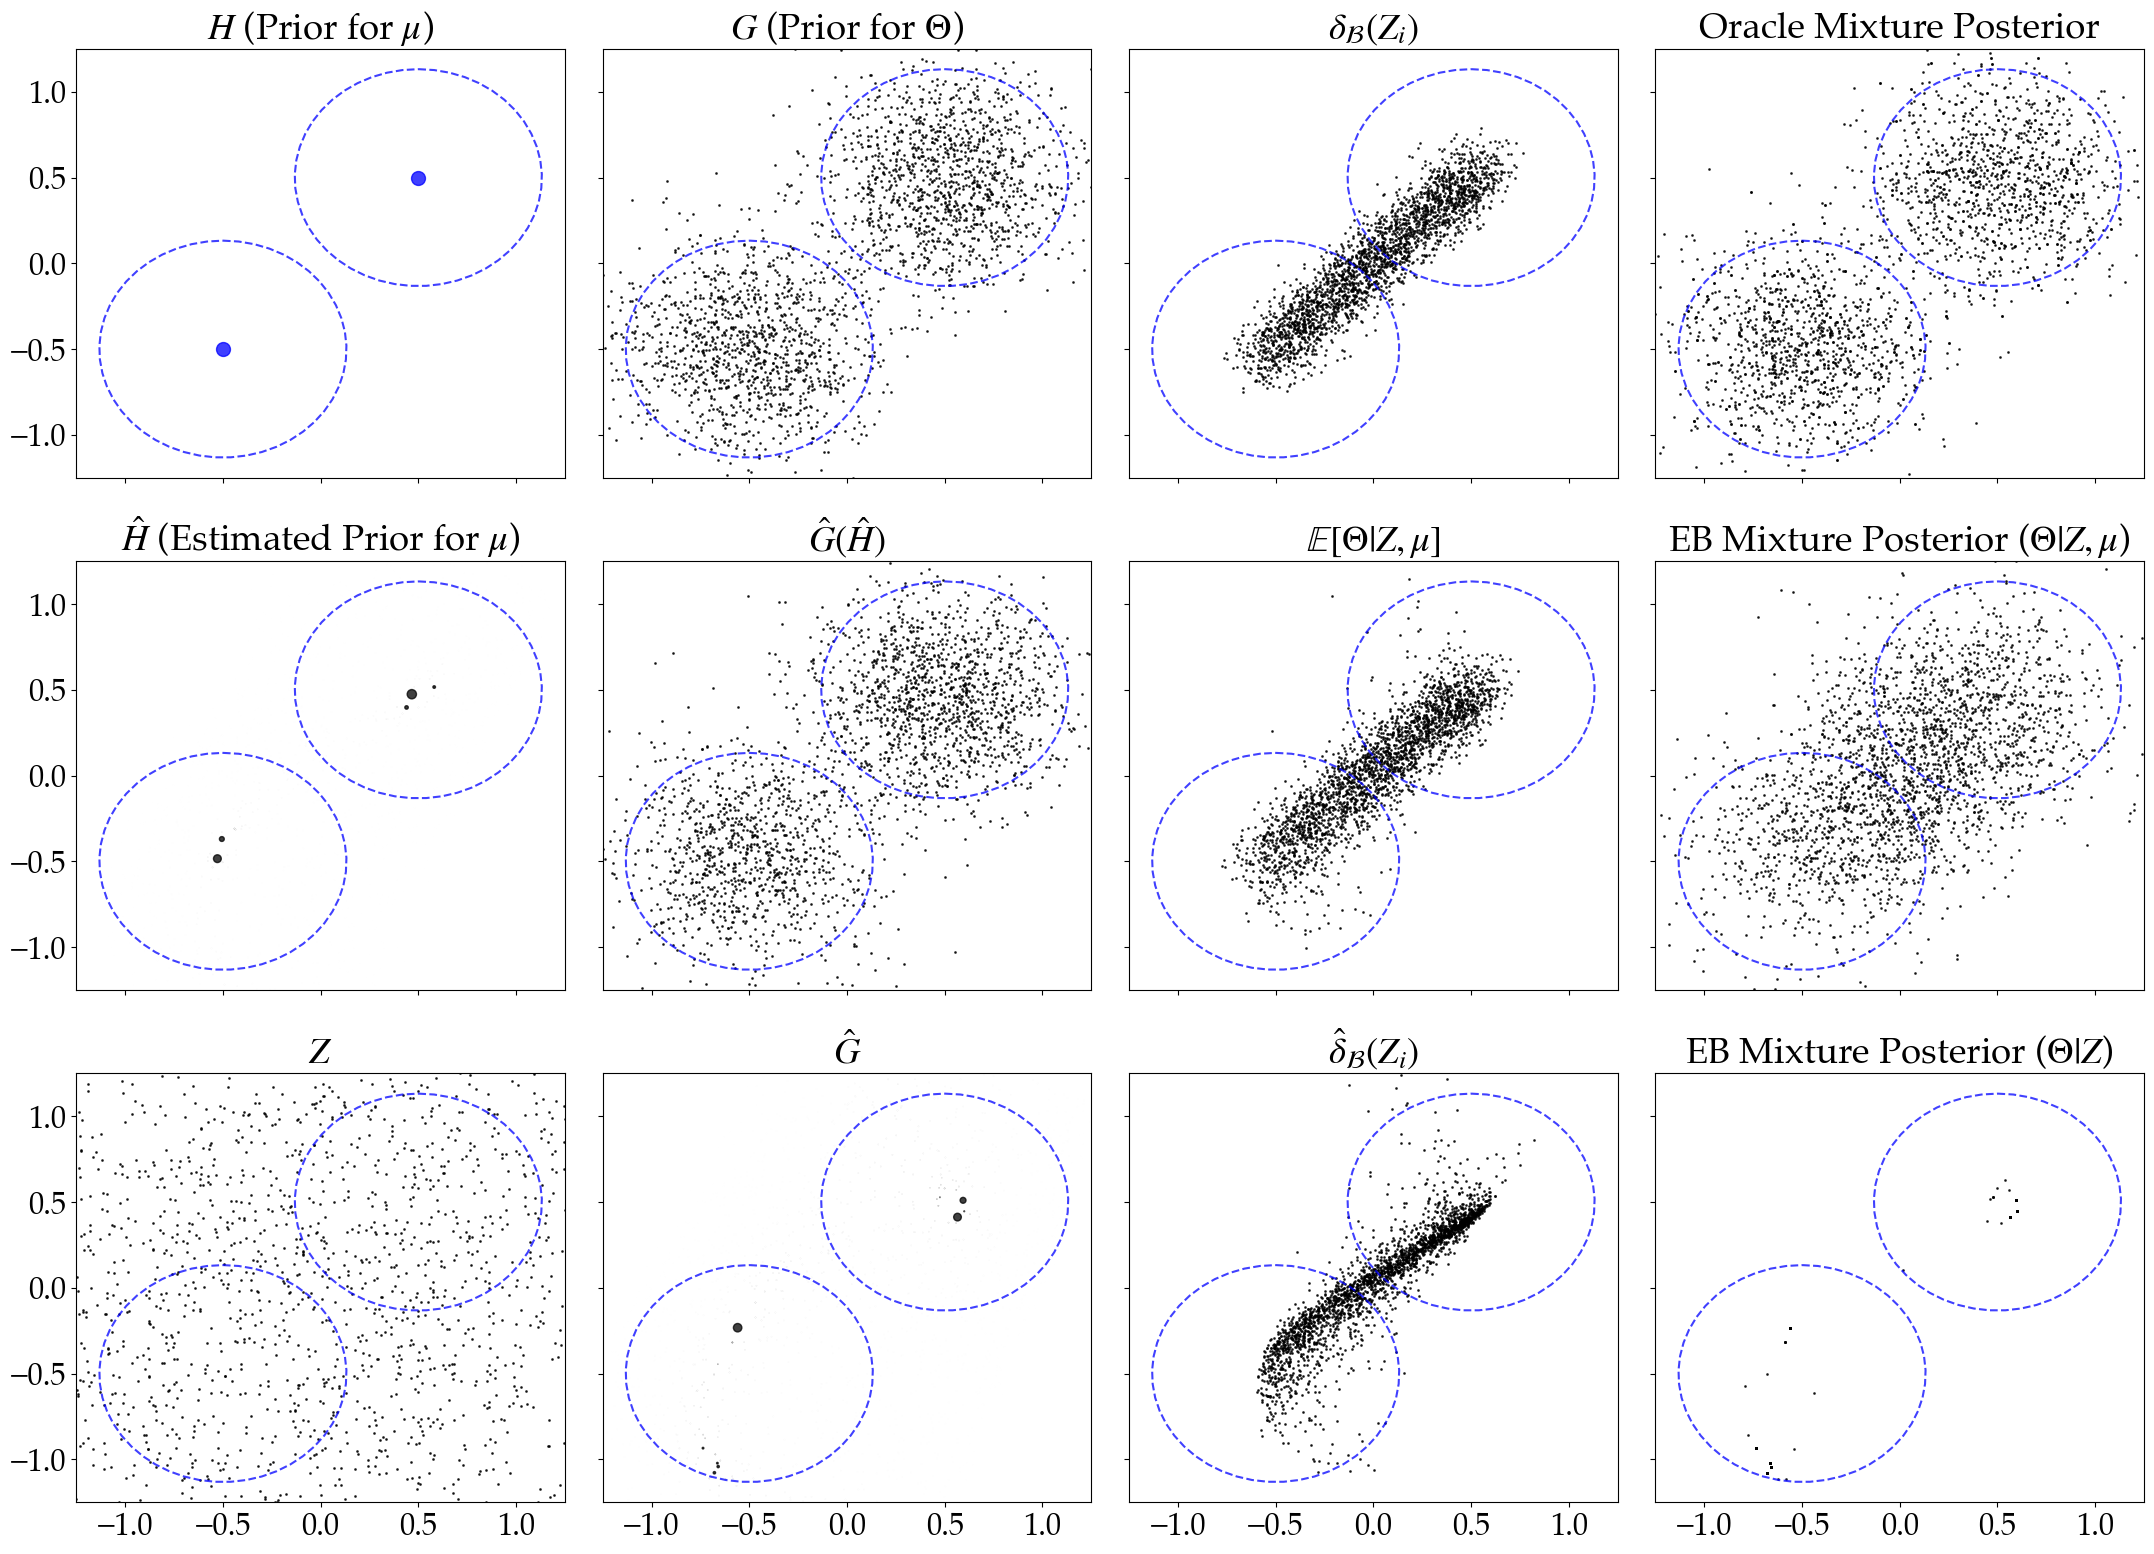

In [115]:
plt.rcParams.update({'font.size': 22, 'mathtext.fontset': 'stix', 'font.family': 'serif', 'font.serif': 'Palatino'})
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(22,16))
Z_alpha = 0.75
Z_s = 1.0
H_s = 100
G_alpha = 0.5

ax[0,0].set_title(r'$H$ (Prior for $\mu$)')
ax[0,0].scatter(centers[:,0], centers[:,1], s=H_s,color='blue', alpha=Z_alpha)

ax[0,1].set_title(r'$G$ (Prior for $\Theta$)')
ax[0,1].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,2].set_title(r'$\delta_{\mathcal{B}}(Z_i)$')
ax[0,2].scatter(ob_means[:,0], ob_means[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[0,3].set_title(r'Oracle Mixture Posterior')
ax[0,3].scatter(ob_samples[:,0], ob_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,0].set_title(r'$\hat{H}$ (Estimated Prior for $\mu$)')
ax[1,0].scatter(eb_model_h.atoms[:,0], eb_model_h.atoms[:,1], s=eb_model_h.weights*H_s,color='black', alpha=Z_alpha)

ax[1,1].set_title(r'$\hat{G}(\hat{H})$')
ax[1,1].scatter(g_hat_samples[:,0], g_hat_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,2].set_title(r'$\mathbb{E}[\Theta|Z, \mu]$')
ax[1,2].scatter(post_theta_means[:,0], post_theta_means[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[1,3].set_title(r'EB Mixture Posterior ($\Theta | Z, \mu$)')
ax[1,3].scatter(post_theta_samples[:,0], post_theta_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,0].set_title(r'$Z$')
ax[2,0].scatter(Z[:,0], Z[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,1].set_title(r'$\hat{G}$')
ax[2,1].scatter(est_g[:,0], est_g[:,1], s=est_g_weights*H_s,color='black', alpha=Z_alpha)

ax[2,2].set_title(r'$\hat{\delta}_{\mathcal{B}}(Z_i)$')
ax[2,2].scatter(eb_means_g[:,0], eb_means_g[:,1], s=Z_s,color='black', alpha=Z_alpha)

ax[2,3].set_title(r'EB Mixture Posterior ($\Theta | Z$)')
ax[2,3].scatter(g_samples[:,0], g_samples[:,1], s=Z_s,color='black', alpha=Z_alpha)


u = np.linspace(0,2*np.pi)
circ1 = center1 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
circ2 = center2 + 2*np.sqrt(tau2)*np.vstack([np.sin(u),np.cos(u)]).T
for i in range(3):
    for j in range(4):
        # if i > 0 or j > 0:
        ax[i,j].plot(circ1[:,0],circ1[:,1],color='blue',linestyle='dashed', alpha=0.75)
        ax[i,j].plot(circ2[:,0],circ2[:,1],color='blue',linestyle='dashed', alpha=0.75)
            # ax[i,j].scatter(Theta[:,0], Theta[:,1], s=Z_s,color='blue', alpha=G_alpha)

plt.xlim([-1.25,1.25])
plt.ylim([-1.25, 1.25])
plt.tight_layout()
